This file can either compute the Wasserstein, Bottleneck or Landscape distances to the 
Wasserstein, Bottleneck or the Landscape barycenters of each class.
It can also compute the respective distances to the origin diagram.

In [138]:
import numpy as np
import pyedflib
import statistics
import plotly.graph_objects as go
import pandas as pd
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, ForgetDimension
import random
from sklearn import preprocessing

# Choose parameters

In [139]:
# Choose if you want to look at EEG or EMG data

#data_type = "EEG" # Does not have an effect yet, will be added later when processing anesthesia data
data_type = "EMG"

In [140]:
# Set the distance metric here

metric = "wasserstein"
#metric = "landscape"
#metric = "bottleneck"

# Load Data

In [141]:
label_list = [0, 1, 2, 3, 4]

In [142]:
# Load persistence diagrams

train_persistence_diagrams = {} # dictionary with labels as keys, persistence diagrams of the respective classes as values
test_persistence_diagrams = {} # dictionary with labels as keys, persistence diagrams of the respective classes as values


for label in label_list:
    train_persistence_diagrams[label] = np.load("Embeddings_and_Persistence_Diagrams/Train_"+str(data_type)+"_PD"+str(label)+".npy", allow_pickle=True)
    test_persistence_diagrams[label] = np.load("Embeddings_and_Persistence_Diagrams/Test_"+str(data_type)+"_PD"+str(label)+".npy", allow_pickle=True)


In [143]:
# Load embeddings

train_embeddings = {} # dictionary with labels as keys, persistence diagrams of the respective classes as values
test_embeddings = {} # dictionary with labels as keys, persistence diagrams of the respective classes as values


for label in label_list:
    train_embeddings[label] = np.load("Embeddings_and_Persistence_Diagrams/Train_"+str(data_type)+"_Embeddings_"+str(label)+"_Dim5.npy", allow_pickle=True)
    test_embeddings[label] = np.load("Embeddings_and_Persistence_Diagrams/Test_"+str(data_type)+"_Embeddings_"+str(label)+"_Dim5.npy", allow_pickle=True)

# Computing the distance to the Wasserstein Barycenter

## Cutting of noise

For the next analyses, we will need to compare persistence diagrams (pairwise). Giotto TDA needs all diagrams to have the same length for this (to have the same amount of holes). We will therefore cut off some "noise" (holes with low persistence) such that all persistence diagrams have the same length.

In [144]:
# Set number of holes of each dimension that are supposed to be kept
if data_type == "EEG":
    no_holes_per_dimension = [63, 37, 2] 
elif data_type == "EMG":
    no_holes_per_dimension = [15, 5, 1] 


In [145]:
def cut_diagrams(persistence_diagrams, no_holes_per_dimension):
    """    Cuts diagrams to the dimensions no_holes_per_dimension and removes diagrams smaller than that.

    Parameters:
    - persistence_diagrams (list of lists): list of persistence diagrams
    - no_holes_per_dimension (list): maximal dimension the persistence diagrams should have, e.g.
    [120, 70, 10] for 120 holes of dimension 0, 70 of dimension 1 and 10 of dimension 2

    Returns:
    Tuple of two lists:
    - shortened diagrams
    - indices of diagrams that were to small and were removed from the list of shortened diagrams
    """
        
    shortened_diagrams = [] # list of diagrams in which non-signicant holes were cut off
    removed_indices = [] # List of indices of the diagrams that are smaller than no_holes_per_dimension and will not be considered

    for diagram_idx, diagram in enumerate(persistence_diagrams): 
        
        most_significant_holes_per_diagram = [] # Holes that are not noise
        should_be_appended = True # Boolean if the diagram index will be added to removed index (False) or not (True)
        holes = {} # Dictionary which will save all holes (values) of each dimension (keys) for each diagram
        
        for hole_dimension, number_of_holes in zip(range(3), no_holes_per_dimension):
            
            # the third entry of each point (hole) in a diagram indicates its dimensionality
            holes[hole_dimension] = diagram[np.where(diagram[:, 2] == hole_dimension)[0]]

            # If the number of holes of this dimension that are supposed to be kept is larger than the number of holes of the diagram
            if number_of_holes > len(holes[hole_dimension]):
                print("Diagram " + str(diagram_idx) + " is shorter than the shortened diagrams, and was removed.")
                print("It has " + str(len(holes[hole_dimension])) + " holes of dimension " + str(hole_dimension))
                should_be_appended = False 
                removed_indices.append(diagram_idx) # Should be sepa rated according to dimension? or not?
                
            # The first and second entries of each hole indicate its birth and death, the difference is the persistence
            # We only want to keep as the as many holes for each dimension as we set no_holes_per_dimension to be
            large_persistence_indices = np.argsort(holes[hole_dimension][:, 0] - holes[hole_dimension][:, 1])[-number_of_holes:]
            
            # For each dimension, getting the holes with the above indices (the holes with the largest persistence)
            significant_holes_with_hole_dimension = holes[hole_dimension][large_persistence_indices, :]
            most_significant_holes_per_diagram.extend(significant_holes_with_hole_dimension)

        if should_be_appended:
            shortened_diagrams.append(most_significant_holes_per_diagram)

    return shortened_diagrams, list(set(removed_indices))

In [146]:
# Label 1
train_shortened_diagrams = {}
test_shortened_diagrams = {}

removed_train_indices = {}
removed_test_indices = {}

for label in label_list:
    train_shortened_diagrams[label], removed_train_indices[label] = cut_diagrams(train_persistence_diagrams[label], no_holes_per_dimension)
    test_shortened_diagrams[label], removed_test_indices[label] = cut_diagrams(test_persistence_diagrams[label], no_holes_per_dimension)

    # Remove embeddings of diagrams that were removed 
    train_embeddings[label] =  np.delete(train_embeddings[label], removed_train_indices[label], 0)
    test_embeddings[label] =  np.delete(test_embeddings[label], removed_test_indices[label], 0)

Diagram 29 is shorter than the shortened diagrams, and was removed.
It has 4 holes of dimension 1
Diagram 11 is shorter than the shortened diagrams, and was removed.
It has 3 holes of dimension 1
Diagram 3 is shorter than the shortened diagrams, and was removed.
It has 4 holes of dimension 1


## Wasserstein Barycenter

The Wasserstein Barycenter is the most representative persistence diagram in a set of diagrams (of one class), so the one with the lowest overall (Wasserstein) distance to all other diagrams. Because it takes long to compute, we will for now only use a part of the data as training data. For now, these training samples can also be in the test set of the simple classifier in the end.

In [147]:
# We will look at 0-, 1- and 2-dimensional holes
homology_dimensions = [0, 1, 2]

# We will use a Vietoris Rips filtrations
persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=10
)

### Computing the Wasserstein Barycenter for all labels

In [148]:
def find_barycenter(shortened_diagrams, train_data_amount, label):
    # Only use parts of the training data to speed things up
    random_diagrams = random.sample(train_shortened_diagrams[label], train_data_amount)

    # Compute the pairwise Wasserstein distances
    pairwise_wasserstein_distances = PairwiseDistance(metric=metric).fit_transform(random_diagrams)

    # For each hole, calculate the sum of distances to all other holes
    sum_distances = [sum(dist) for dist in pairwise_wasserstein_distances]

    # Find the index of the Wasserstein barycenter
    most_representative_index = np.argmin(sum_distances)

    # Unshortened Wasserstein Barycenter for our label
    most_representative_diagram = persistence.fit_transform_plot([train_embeddings[label][most_representative_index]])

    return most_representative_diagram
    

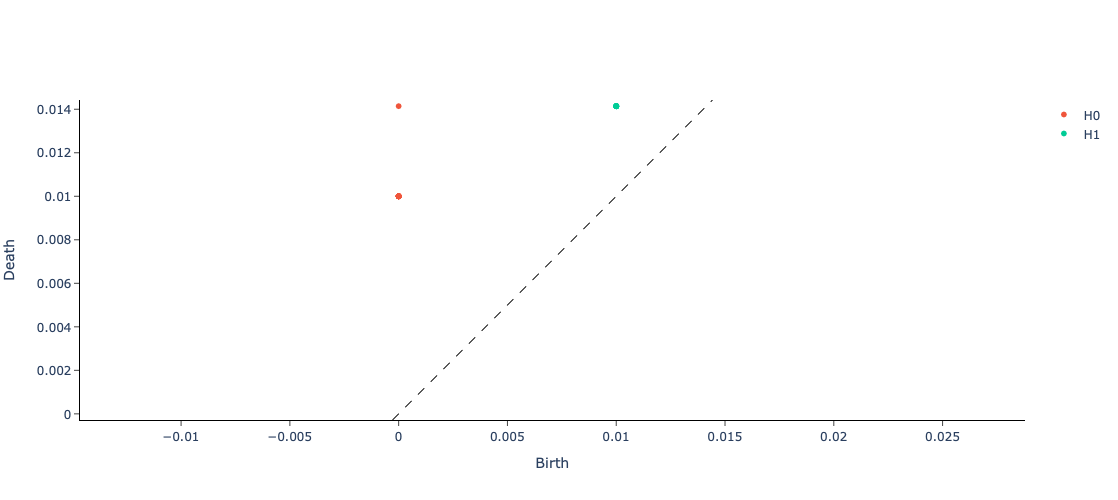

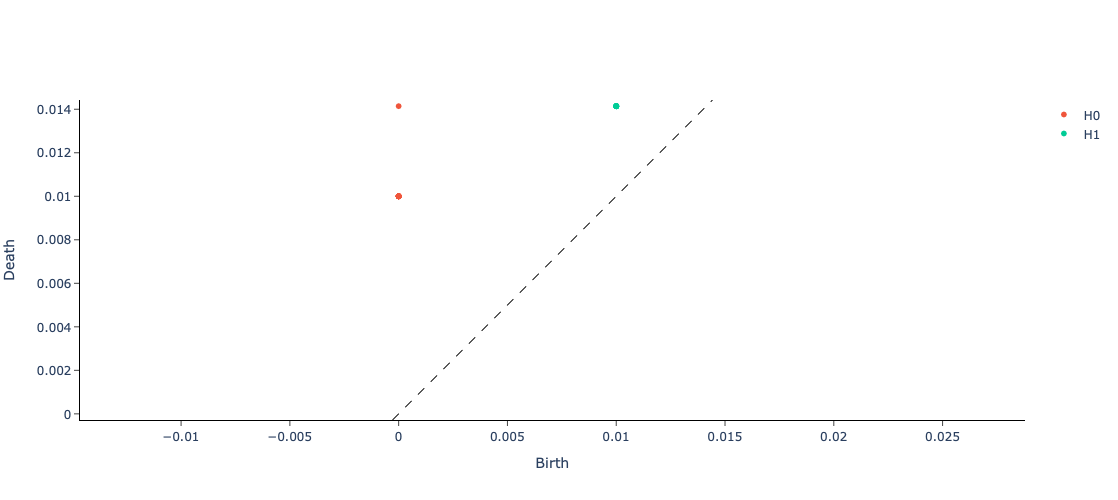

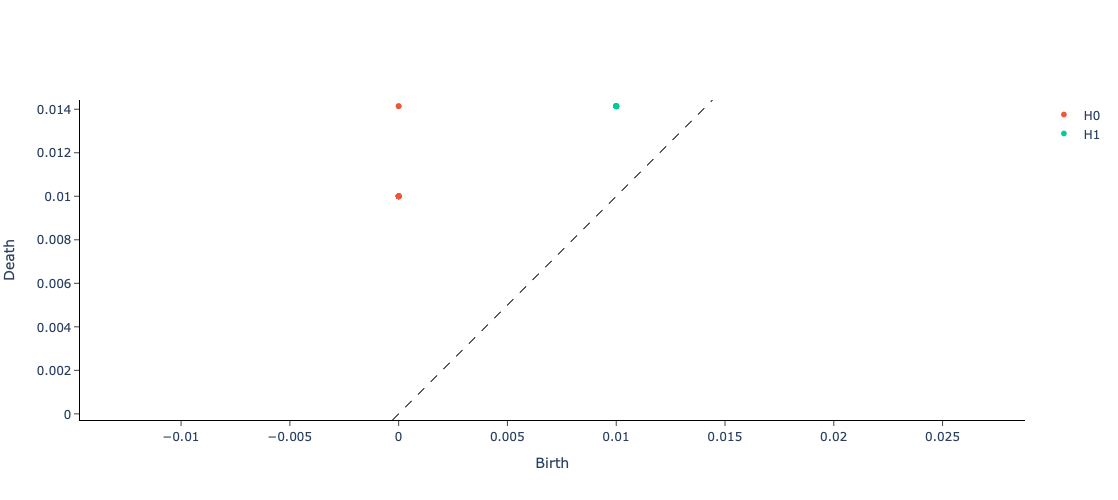

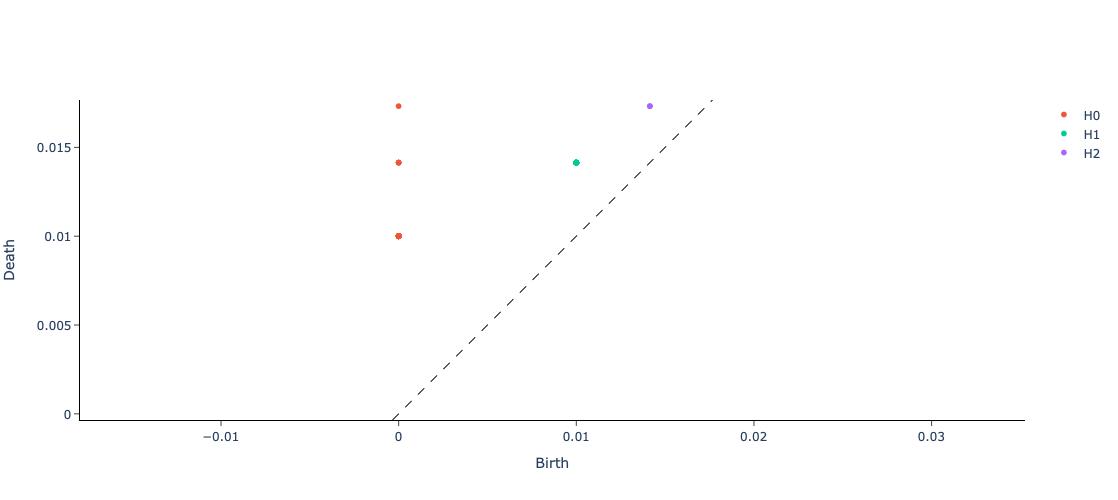

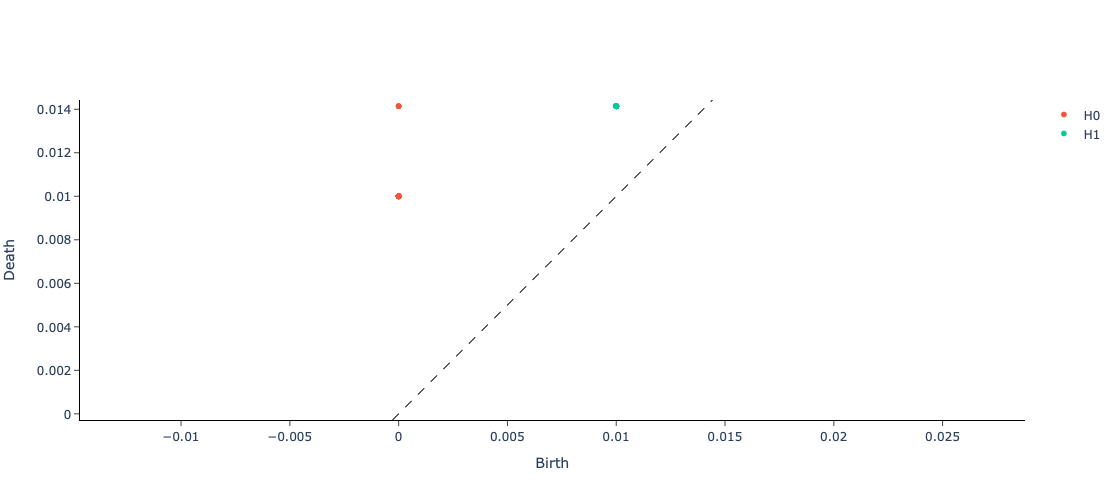

In [149]:
# Finding the most representative diagrams for all labels

representative_diagrams = {} # barycenters for all labels

representative_diagrams[0] = find_barycenter(train_shortened_diagrams, len(train_shortened_diagrams[0]), 0)
representative_diagrams[1] = find_barycenter(train_shortened_diagrams, len(train_shortened_diagrams[1]), 1)
representative_diagrams[2] = find_barycenter(train_shortened_diagrams, len(train_shortened_diagrams[2]), 2)
representative_diagrams[3] = find_barycenter(train_shortened_diagrams, len(train_shortened_diagrams[3]), 3)
representative_diagrams[4] = find_barycenter(train_shortened_diagrams, len(train_shortened_diagrams[4]), 4)

### Computing the distances of the test diagrams to the most representative diagram of each class

In [150]:
# Shorten barycenters to make them comparable to the other shortened diagrams

shortened_barycenters = {}

for label in label_list:
    shortened_barycenters[label], _ = cut_diagrams([representative_diagrams[label][0]], no_holes_per_dimension)


In [151]:
# TRAIN DATA 

train_distances_to_barycenter_0 = {}
train_distances_to_barycenter_1 = {}
train_distances_to_barycenter_2 = {}
train_distances_to_barycenter_3 = {}
train_distances_to_barycenter_4 = {}


for label in label_list:

    # Initialize lists of distances
    train_distances_to_barycenter_0[label] = []
    train_distances_to_barycenter_1[label] = []
    train_distances_to_barycenter_2[label] = []
    train_distances_to_barycenter_3[label] = []
    train_distances_to_barycenter_4[label] = []

    
    # Loop through all train diagrams of our label
    for diagram in train_shortened_diagrams[label]:
        # Barycenter of class 0
        dist = PairwiseDistance(metric=metric).fit_transform([diagram, shortened_barycenters[0][0]])
        train_distances_to_barycenter_0[label].append(max(dist[0]))

        # Barycenter of class 1
        dist = PairwiseDistance(metric=metric).fit_transform([diagram, shortened_barycenters[1][0]])
        train_distances_to_barycenter_1[label].append(max(dist[0]))

        # Barycenter of class 2
        dist = PairwiseDistance(metric=metric).fit_transform([diagram, shortened_barycenters[2][0]])
        train_distances_to_barycenter_2[label].append(max(dist[0]))

        # Barycenter of class 3
        dist = PairwiseDistance(metric=metric).fit_transform([diagram, shortened_barycenters[3][0]])
        train_distances_to_barycenter_3[label].append(max(dist[0]))

        # Barycenter of class 4
        dist = PairwiseDistance(metric=metric).fit_transform([diagram, shortened_barycenters[3][0]])
        train_distances_to_barycenter_4[label].append(max(dist[0]))

In [152]:
# TEST DATA 

test_distances_to_barycenter_0 = {}
test_distances_to_barycenter_1 = {}
test_distances_to_barycenter_2 = {}
test_distances_to_barycenter_3 = {}
test_distances_to_barycenter_4 = {}


for label in label_list:

    # Initialize lists of distances
    test_distances_to_barycenter_0[label] = []
    test_distances_to_barycenter_1[label] = []
    test_distances_to_barycenter_2[label] = []
    test_distances_to_barycenter_3[label] = []
    test_distances_to_barycenter_4[label] = []

    
    # Loop through all test diagrams of our label
    for diagram in test_shortened_diagrams[label]:
        # Barycenter of class 0
        dist = PairwiseDistance(metric=metric).fit_transform([diagram, shortened_barycenters[0][0]])
        test_distances_to_barycenter_0[label].append(max(dist[0]))

        # Barycenter of class 1
        dist = PairwiseDistance(metric=metric).fit_transform([diagram, shortened_barycenters[1][0]])
        test_distances_to_barycenter_1[label].append(max(dist[0]))

        # Barycenter of class 2
        dist = PairwiseDistance(metric=metric).fit_transform([diagram, shortened_barycenters[2][0]])
        test_distances_to_barycenter_2[label].append(max(dist[0]))

        # Barycenter of class 3
        dist = PairwiseDistance(metric=metric).fit_transform([diagram, shortened_barycenters[3][0]])
        test_distances_to_barycenter_3[label].append(max(dist[0]))

        # Barycenter of class 4
        dist = PairwiseDistance(metric=metric).fit_transform([diagram, shortened_barycenters[3][0]])
        test_distances_to_barycenter_4[label].append(max(dist[0]))

## Insert invalid distance for diagrams that were removed before

In [153]:
# Add the removed diagrams again, with a distance that is higher than the maximal distance out of the other diagrams
# At a later step, the "outlier" diagrams should be labelled as outliers beforehand

invalid_distance = -1

for label in label_list:
    
    # Train data
    for idx in removed_train_indices[label]: 
        train_distances_to_barycenter_0[label].insert(idx, invalid_distance)
        train_distances_to_barycenter_1[label].insert(idx, invalid_distance)
        train_distances_to_barycenter_2[label].insert(idx, invalid_distance)
        train_distances_to_barycenter_3[label].insert(idx, invalid_distance)
        train_distances_to_barycenter_4[label].insert(idx, invalid_distance)


    # Test data
    for idx in removed_test_indices[label]: 
        test_distances_to_barycenter_0[label].insert(idx, invalid_distance)
        test_distances_to_barycenter_1[label].insert(idx, invalid_distance)
        test_distances_to_barycenter_2[label].insert(idx, invalid_distance)
        test_distances_to_barycenter_3[label].insert(idx, invalid_distance)
        test_distances_to_barycenter_4[label].insert(idx, invalid_distance)

# Compute the distance to the origin diagram 

The origin diagram just has points on the diagonal.

Later in the classification, adding this feature does not improve (nor worsen) the accuracy when using the distances to the barycenters as the only other features, but using the distance to the origin diagram as a standalone feature still leads to an accuracy of 95%.

In [154]:
# TRAIN DATA 

# Dictionary with labels as keys and distances of train diagrams of each label to origin diagram as values
train_distances_to_origin_diagram = {}

for label in label_list:

    # Initialize distances of train diagrams to origin diagram
    train_distances_to_origin_diagram[label] = []
    
    # Loop through all train diagrams of our label
    for diagram in train_shortened_diagrams[label]:
        
        # origin diagram fitting to diagram
        origin_diagram = [np.array([hole[0], hole[0], hole[2]]) for hole in diagram]
        dist = PairwiseDistance(metric=metric).fit_transform([diagram, origin_diagram])
        train_distances_to_origin_diagram[label].append(max(dist[0]))

    for idx in removed_train_indices[label]: # Train data
        train_distances_to_origin_diagram[label].insert(idx, invalid_distance)



# TRAIN DATA 

# Dictionary with labels as keys and distances of train diagrams of each label to origin diagram as values
test_distances_to_origin_diagram = {}

for label in label_list:

    # Initialize distances of train diagrams to origin diagram
    test_distances_to_origin_diagram[label] = []
    
    # Loop through all train diagrams of our label
    for diagram in test_shortened_diagrams[label]:
        
        # origin diagram fitting to diagram
        origin_diagram = [np.array([hole[0], hole[0], hole[2]]) for hole in diagram]
        dist = PairwiseDistance(metric=metric).fit_transform([diagram, origin_diagram])
        test_distances_to_origin_diagram[label].append(max(dist[0]))

    for idx in removed_test_indices[label]: # Train data
        test_distances_to_origin_diagram[label].insert(idx, invalid_distance)


In [155]:
# Save training data features
# TODO add metric as global variable

def create_feature_df(data_type, distances_to_barycenter_0, distances_to_barycenter_1, distances_to_barycenter_2, distances_to_barycenter_3, distances_to_barycenter_4, distances_to_origin, label):
    """
    Create DataFrame for each label from features

    Parameters:
    - distances_to_barycenter_1 (list): distances to Barycenter of class 1
    - distances_to_barycenter_3 (list): distances to Barycenter of class 3
    - distances_to_barycenter_5 (list): distances to Barycenter of class 5
    - distances_to_barycenter_7 (list): distances to Barycenter of class 7
    - label (int): Label for which we want to create a dataframe. 1, 3, 5 or 7.

    Returns:
    - Feature DataFrame (DataFrame)
    """

    train_feature_df = pd.DataFrame()
    train_feature_df[str(data_type)+"_Distance_to_"+str(metric)+"_Barycenter0"] = distances_to_barycenter_0[label]
    train_feature_df[str(data_type)+"_Distance_to_"+str(metric)+"_Barycenter1"] = distances_to_barycenter_1[label]
    train_feature_df[str(data_type)+"_Distance_to_"+str(metric)+"_Barycenter2"] = distances_to_barycenter_2[label]
    train_feature_df[str(data_type)+"_Distance_to_"+str(metric)+"_Barycenter3"] = distances_to_barycenter_3[label]
    train_feature_df[str(data_type)+"_Distance_to_"+str(metric)+"_Barycenter4"] = distances_to_barycenter_4[label]

    train_feature_df[str(data_type)+"_"+str(metric)+"_Distance_to_Origin_Diagram"] = distances_to_origin[label]

    train_feature_df["Label"] = label

    return train_feature_df


In [156]:
# Create dataframes from features
train_feature_dataframes = {}
test_feature_dataframes = {}


for label in label_list:
    train_feature_dataframes[label] = create_feature_df(data_type, train_distances_to_barycenter_0, train_distances_to_barycenter_1, \
                                                        train_distances_to_barycenter_2, train_distances_to_barycenter_3, \
                                                        train_distances_to_barycenter_4, train_distances_to_origin_diagram, label) 
    
    test_feature_dataframes[label] = create_feature_df(data_type, test_distances_to_barycenter_0, test_distances_to_barycenter_1, \
                                                        test_distances_to_barycenter_2, test_distances_to_barycenter_3, \
                                                        test_distances_to_barycenter_4, test_distances_to_origin_diagram, label) 

In [157]:
# Save concatenated dataframes 

# Train dataframe
train_feature_df = pd.concat([train_feature_dataframes[0], train_feature_dataframes[1], train_feature_dataframes[2], \
train_feature_dataframes[3], train_feature_dataframes[4]])

train_feature_df.to_csv("Features/Train_"+str(data_type)+"_"+str(metric)+"_Features.csv")


# Test dataframe
test_feature_df = pd.concat([test_feature_dataframes[0], test_feature_dataframes[1], test_feature_dataframes[2], \
                             test_feature_dataframes[3], test_feature_dataframes[4]], ignore_index=True)

test_feature_df.to_csv("Features/Test_"+str(data_type)+"_"+str(metric)+"_Features.csv")

## Save shortened diagrams

In [158]:
for label in label_list:
    np.save('Embeddings_and_Persistence_Diagrams/Train_'+str(data_type)+'_Removed_Indices'+str(label)+'.npy', np.array(removed_train_indices[label], dtype=object), allow_pickle=True)
    np.save('Embeddings_and_Persistence_Diagrams/Test_'+str(data_type)+'_Removed_Indices'+str(label)+'.npy', np.array(removed_test_indices[label], dtype=object), allow_pickle=True)


In [159]:
for label in label_list:
    np.save('Embeddings_and_Persistence_Diagrams/Train_'+str(data_type)+'_Shortened_Diagrams'+str(label)+'.npy', np.array(train_shortened_diagrams[label], dtype=object), allow_pickle=True)
    np.save('Embeddings_and_Persistence_Diagrams/Test_'+str(data_type)+'_Shortened_Diagrams'+str(label)+'.npy', np.array(test_shortened_diagrams[label], dtype=object), allow_pickle=True)

In [160]:
# Save shortened barycenters for data exploration
for label in label_list:
    np.save('Embeddings_and_Persistence_Diagrams/'+str(data_type)+'_'+str(metric)+'_Barycenter_class_'+str(label)+'.npy', np.array(shortened_barycenters[label], dtype=object), allow_pickle=True)